# 07_02 – Cross-Validation (Transformer-Modelle: BERT & DistilBERT)

Ziel: Robuste Evaluation mittels 5-fold Stratified Cross-Validation für Transformer-Modelle.
Pro Fold wird das Modell neu initialisiert und auf dem Trainingsfold fine-getuned.

**Modelle:**
- `bert-base-uncased` (110M Parameter)
- `distilbert-base-uncased` (66M Parameter)

**Output:**
- Accuracy und Macro-F1 (Mittelwert ± Standardabweichung)
- Aggregierte Confusion Matrix
- Vergleichsplot mit Baseline

In [1]:
from pathlib import Path
import time
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed,
)

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results" / "cross_validation"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("CUDA available:", torch.cuda.is_available())
print("DATA_CSV:", DATA_CSV)
print("RESULTS_DIR:", RESULTS_DIR)

CUDA available: True
DATA_CSV: c:\CAS\cas-ml-document-classification\data\processed\bbc_news.csv
RESULTS_DIR: c:\CAS\cas-ml-document-classification\results\cross_validation


Daten laden + Label Mapping

In [2]:
df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

print("Samples:", len(X))
print("Classes:", labels_sorted)


Samples: 2225
Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


Tokenizer + Tokenize-Funktion (Tokenzier einmal laden, nicht pro Feld)

In [3]:
# Modelle, die wir vergleichen wollen
MODEL_NAMES = [
    "distilbert-base-uncased",
    "bert-base-uncased"
]

MAX_LENGTH = 256

# Tokenizer werden pro Modell geladen (im Loop)
def tokenize_batch(batch, tok, max_len):
    return tok(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=max_len
    )

Metrics

In [4]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    mf1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": mf1}


Trainer Builder

In [5]:
def build_trainer(model_name, train_ds, eval_ds, tokenizer, fold_id, seed=42,
                  epochs=2, batch_size=16, lr=2e-5):
    set_seed(seed)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    )

    args = TrainingArguments(
        output_dir=str(RESULTS_DIR / f"tmp_{model_name.replace('/', '_')}_fold_{fold_id}"),
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="no",
        report_to="none",
        seed=seed
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    return trainer

Cross-Validation Loop

In [6]:
N_SPLITS = 5     # konsistent mit Baseline-CV
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
SEED = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

all_fold_rows = []           # für Summary CSV
all_predictions = {}         # für Confusion Matrix: {model_name: {"y_true": [], "y_pred": []}}

for model_name in MODEL_NAMES:
    print(f"\n{'='*60}")
    print(f"Modell: {model_name}")
    print(f"{'='*60}")
    
    # Tokenizer für dieses Modell laden
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Tokenize-Funktion mit diesem Tokenizer
    def tok_fn(batch):
        return tokenize_batch(batch, tokenizer, MAX_LENGTH)
    
    # Predictions sammeln für Confusion Matrix
    y_true_all = []
    y_pred_all = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n--- Fold {fold}/{N_SPLITS} ({model_name}) ---")
        t0 = time.time()

        X_tr, y_tr = X[train_idx], y[train_idx]
        X_va, y_va = X[val_idx], y[val_idx]

        train_ds = Dataset.from_dict({"text": list(X_tr), "label": list(y_tr)}).map(tok_fn, batched=True)
        val_ds   = Dataset.from_dict({"text": list(X_va), "label": list(y_va)}).map(tok_fn, batched=True)

        train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
        val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

        trainer = build_trainer(
            model_name,
            train_ds, val_ds,
            tokenizer,
            fold_id=fold,
            seed=SEED,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            lr=LR
        )

        trainer.train()
        res = trainer.evaluate()
        
        # Predictions für Confusion Matrix
        preds_output = trainer.predict(val_ds)
        preds = np.argmax(preds_output.predictions, axis=1)
        y_true_all.extend(y_va.tolist())
        y_pred_all.extend(preds.tolist())
        
        elapsed = time.time() - t0

        all_fold_rows.append({
            "model": model_name,
            "fold": fold,
            "n_splits": N_SPLITS,
            "max_length": MAX_LENGTH,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "eval_accuracy": float(res["eval_accuracy"]),
            "eval_macro_f1": float(res["eval_macro_f1"]),
            "eval_loss": float(res["eval_loss"]),
            "time_sec": round(elapsed, 1)
        })
        
        print(f"   Accuracy: {res['eval_accuracy']:.4f}, F1: {res['eval_macro_f1']:.4f}, Time: {elapsed:.1f}s")
    
    # Predictions für dieses Modell speichern
    all_predictions[model_name] = {"y_true": y_true_all, "y_pred": y_pred_all}

df_cv = pd.DataFrame(all_fold_rows)
print("\n\n=== Alle Fold-Ergebnisse ===")
df_cv


Modell: distilbert-base-uncased

--- Fold 1/5 (distilbert-base-uncased) ---


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.15202677249908447, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.9680865344921188, 'eval_runtime': 0.6054, 'eval_samples_per_second': 735.084, 'eval_steps_per_second': 46.252, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.13231292366981506, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.967638415721327, 'eval_runtime': 0.6094, 'eval_samples_per_second': 730.254, 'eval_steps_per_second': 45.949, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.11425045877695084, 'eval_accuracy': 0.9707865168539326, 'eval_macro_f1': 0.9703086051310346, 'eval_runtime': 0.6104, 'eval_samples_per_second': 729.011, 'eval_steps_per_second': 45.87, 'epoch': 3.0}
{'train_runtime': 24.972, 'train_samples_per_second': 213.84, 'train_steps_per_second': 13.455, 'train_loss': 0.25093809763590497, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9708, F1: 0.9703, Time: 27.4s

--- Fold 2/5 (distilbert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.12520922720432281, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9773854381739173, 'eval_runtime': 0.6125, 'eval_samples_per_second': 726.539, 'eval_steps_per_second': 45.715, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.04927444830536842, 'eval_accuracy': 0.9887640449438202, 'eval_macro_f1': 0.9887900184616463, 'eval_runtime': 0.6101, 'eval_samples_per_second': 729.346, 'eval_steps_per_second': 45.891, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.04509185627102852, 'eval_accuracy': 0.9887640449438202, 'eval_macro_f1': 0.9890814755563169, 'eval_runtime': 0.6085, 'eval_samples_per_second': 731.267, 'eval_steps_per_second': 46.012, 'epoch': 3.0}
{'train_runtime': 24.8577, 'train_samples_per_second': 214.823, 'train_steps_per_second': 13.517, 'train_loss': 0.25753280094691683, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9888, F1: 0.9891, Time: 26.9s

--- Fold 3/5 (distilbert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.1302291452884674, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9779311651135523, 'eval_runtime': 0.6095, 'eval_samples_per_second': 730.123, 'eval_steps_per_second': 45.94, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08694478869438171, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9779212967537612, 'eval_runtime': 0.6124, 'eval_samples_per_second': 726.627, 'eval_steps_per_second': 45.72, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08620492368936539, 'eval_accuracy': 0.9797752808988764, 'eval_macro_f1': 0.9801381883447821, 'eval_runtime': 0.6126, 'eval_samples_per_second': 726.371, 'eval_steps_per_second': 45.704, 'epoch': 3.0}
{'train_runtime': 24.9354, 'train_samples_per_second': 214.153, 'train_steps_per_second': 13.475, 'train_loss': 0.258808658236549, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9798, F1: 0.9801, Time: 27.0s

--- Fold 4/5 (distilbert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.11734195798635483, 'eval_accuracy': 0.9842696629213483, 'eval_macro_f1': 0.9840324974594118, 'eval_runtime': 0.6124, 'eval_samples_per_second': 726.657, 'eval_steps_per_second': 45.722, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.0898321196436882, 'eval_accuracy': 0.9797752808988764, 'eval_macro_f1': 0.9801034843523067, 'eval_runtime': 0.6113, 'eval_samples_per_second': 727.933, 'eval_steps_per_second': 45.803, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.059310268610715866, 'eval_accuracy': 0.9887640449438202, 'eval_macro_f1': 0.9883089072350966, 'eval_runtime': 0.6164, 'eval_samples_per_second': 721.904, 'eval_steps_per_second': 45.423, 'epoch': 3.0}
{'train_runtime': 24.686, 'train_samples_per_second': 216.317, 'train_steps_per_second': 13.611, 'train_loss': 0.257712341490246, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9888, F1: 0.9883, Time: 26.8s

--- Fold 5/5 (distilbert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.1367780864238739, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9771995000085616, 'eval_runtime': 0.6057, 'eval_samples_per_second': 734.656, 'eval_steps_per_second': 46.226, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.10098564624786377, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9774911091159437, 'eval_runtime': 0.5954, 'eval_samples_per_second': 747.362, 'eval_steps_per_second': 47.025, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.10223868489265442, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9775061608786156, 'eval_runtime': 0.598, 'eval_samples_per_second': 744.169, 'eval_steps_per_second': 46.824, 'epoch': 3.0}
{'train_runtime': 24.3553, 'train_samples_per_second': 219.254, 'train_steps_per_second': 13.796, 'train_loss': 0.2521371160234724, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9775, F1: 0.9775, Time: 26.5s

Modell: bert-base-uncased

--- Fold 1/5 (bert-base-uncased) ---


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.15557214617729187, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.9676598018027833, 'eval_runtime': 1.0102, 'eval_samples_per_second': 440.516, 'eval_steps_per_second': 27.718, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.13026155531406403, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.9676365583491432, 'eval_runtime': 1.012, 'eval_samples_per_second': 439.713, 'eval_steps_per_second': 27.667, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.11191186308860779, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9767114858119929, 'eval_runtime': 1.0104, 'eval_samples_per_second': 440.429, 'eval_steps_per_second': 27.712, 'epoch': 3.0}
{'train_runtime': 42.1467, 'train_samples_per_second': 126.7, 'train_steps_per_second': 7.972, 'train_loss': 0.288715816679455, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9775, F1: 0.9767, Time: 45.2s

--- Fold 2/5 (bert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.09759997576475143, 'eval_accuracy': 0.9820224719101124, 'eval_macro_f1': 0.9815022403334354, 'eval_runtime': 1.0124, 'eval_samples_per_second': 439.537, 'eval_steps_per_second': 27.656, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.048647504299879074, 'eval_accuracy': 0.9887640449438202, 'eval_macro_f1': 0.9887149027252227, 'eval_runtime': 1.0107, 'eval_samples_per_second': 440.28, 'eval_steps_per_second': 27.703, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.051921527832746506, 'eval_accuracy': 0.9865168539325843, 'eval_macro_f1': 0.9865473862362087, 'eval_runtime': 1.0074, 'eval_samples_per_second': 441.715, 'eval_steps_per_second': 27.793, 'epoch': 3.0}
{'train_runtime': 42.3508, 'train_samples_per_second': 126.09, 'train_steps_per_second': 7.934, 'train_loss': 0.2619132541474842, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9865, F1: 0.9865, Time: 45.6s

--- Fold 3/5 (bert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.1030709445476532, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9782477154935296, 'eval_runtime': 1.0143, 'eval_samples_per_second': 438.71, 'eval_steps_per_second': 27.604, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.06071888655424118, 'eval_accuracy': 0.9865168539325843, 'eval_macro_f1': 0.9870821295259585, 'eval_runtime': 1.0106, 'eval_samples_per_second': 440.334, 'eval_steps_per_second': 27.706, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.06824392825365067, 'eval_accuracy': 0.9797752808988764, 'eval_macro_f1': 0.9802285497905652, 'eval_runtime': 1.0255, 'eval_samples_per_second': 433.935, 'eval_steps_per_second': 27.304, 'epoch': 3.0}
{'train_runtime': 42.3965, 'train_samples_per_second': 125.954, 'train_steps_per_second': 7.925, 'train_loss': 0.2503754752022879, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9798, F1: 0.9802, Time: 45.7s

--- Fold 4/5 (bert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.125922292470932, 'eval_accuracy': 0.9707865168539326, 'eval_macro_f1': 0.9700674271964594, 'eval_runtime': 1.0154, 'eval_samples_per_second': 438.265, 'eval_steps_per_second': 27.576, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.07085758447647095, 'eval_accuracy': 0.9797752808988764, 'eval_macro_f1': 0.9797051673323727, 'eval_runtime': 1.0562, 'eval_samples_per_second': 421.305, 'eval_steps_per_second': 26.509, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.03062930330634117, 'eval_accuracy': 0.9932584269662922, 'eval_macro_f1': 0.9933436504115367, 'eval_runtime': 1.0494, 'eval_samples_per_second': 424.047, 'eval_steps_per_second': 26.682, 'epoch': 3.0}
{'train_runtime': 43.0479, 'train_samples_per_second': 124.048, 'train_steps_per_second': 7.805, 'train_loss': 0.2834228106907436, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9933, F1: 0.9933, Time: 46.4s

--- Fold 5/5 (bert-base-uncased) ---


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.14574310183525085, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.9685759186370715, 'eval_runtime': 1.0453, 'eval_samples_per_second': 425.72, 'eval_steps_per_second': 26.787, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08280686289072037, 'eval_accuracy': 0.9820224719101124, 'eval_macro_f1': 0.9819709097290126, 'eval_runtime': 1.0485, 'eval_samples_per_second': 424.418, 'eval_steps_per_second': 26.705, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08445370942354202, 'eval_accuracy': 0.9797752808988764, 'eval_macro_f1': 0.9796845473367213, 'eval_runtime': 1.0433, 'eval_samples_per_second': 426.54, 'eval_steps_per_second': 26.838, 'epoch': 3.0}
{'train_runtime': 43.4987, 'train_samples_per_second': 122.762, 'train_steps_per_second': 7.724, 'train_loss': 0.2775763102940151, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

   Accuracy: 0.9798, F1: 0.9797, Time: 46.8s


=== Alle Fold-Ergebnisse ===


,model,fold,n_splits,max_length,epochs,batch_size,lr,eval_accuracy,eval_macro_f1,eval_loss,time_sec
0,distilbert-base-uncased,1,5,256,3,16,0.00002,0.970787,0.970309,0.114250,27.4
1,distilbert-base-uncased,2,5,256,3,16,0.00002,0.988764,0.989081,0.045092,26.9
2,distilbert-base-uncased,3,5,256,3,16,0.00002,0.979775,0.980138,0.086205,27.0
3,distilbert-base-uncased,4,5,256,3,16,0.00002,0.988764,0.988309,0.059310,26.8
4,distilbert-base-uncased,5,5,256,3,16,0.00002,0.977528,0.977506,0.102239,26.5
5,bert-base-uncased,1,5,256,3,16,0.00002,0.977528,0.976711,0.111912,45.2
6,bert-base-uncased,2,5,256,3,16,0.00002,0.986517,0.986547,0.051922,45.6
7,bert-base-uncased,3,5,256,3,16,0.00002,0.979775,0.980229,0.068244,45.7
8,bert-base-uncased,4,5,256,3,16,0.00002,0.993258,0.993344,0.030629,46.4
9,bert-base-uncased,5,5,256,3,16,0.00002,0.979775,0.979685,0.084454,46.8


Mean / Std berechnen

In [7]:
# Summary Statistics pro Modell
summary = df_cv.groupby("model").agg({
    "eval_accuracy": ["mean", "std"],
    "eval_macro_f1": ["mean", "std"],
    "time_sec": "sum"
}).round(4)

summary.columns = ["acc_mean", "acc_std", "f1_mean", "f1_std", "total_time_sec"]
summary = summary.reset_index()

# CSV speichern
for model_name in MODEL_NAMES:
    model_df = df_cv[df_cv["model"] == model_name].copy()
    csv_path = RESULTS_DIR / f"cv_{model_name.replace('/', '_')}_{N_SPLITS}fold_summary.csv"
    model_df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

print("\n=== Summary ===")
summary

Saved: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_distilbert-base-uncased_5fold_summary.csv
Saved: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_bert-base-uncased_5fold_summary.csv

=== Summary ===


,model,acc_mean,acc_std,f1_mean,f1_std,total_time_sec
0,bert-base-uncased,0.9834,0.0065,0.9833,0.0067,229.7
1,distilbert-base-uncased,0.9811,0.0077,0.9811,0.0078,134.6


Expoert CSV

In [8]:
# Aggregiertes Summary (alle Modelle in einer Datei)
all_summary_path = RESULTS_DIR / f"cv_transformer_all_{N_SPLITS}fold_summary.csv"
df_cv.to_csv(all_summary_path, index=False)
print(f"Saved combined results: {all_summary_path}")

Saved combined results: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_transformer_all_5fold_summary.csv


## Normalized Confusion Matrix (aggregiert über alle Folds)

Saved: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_transformer_confusion_matrices.png


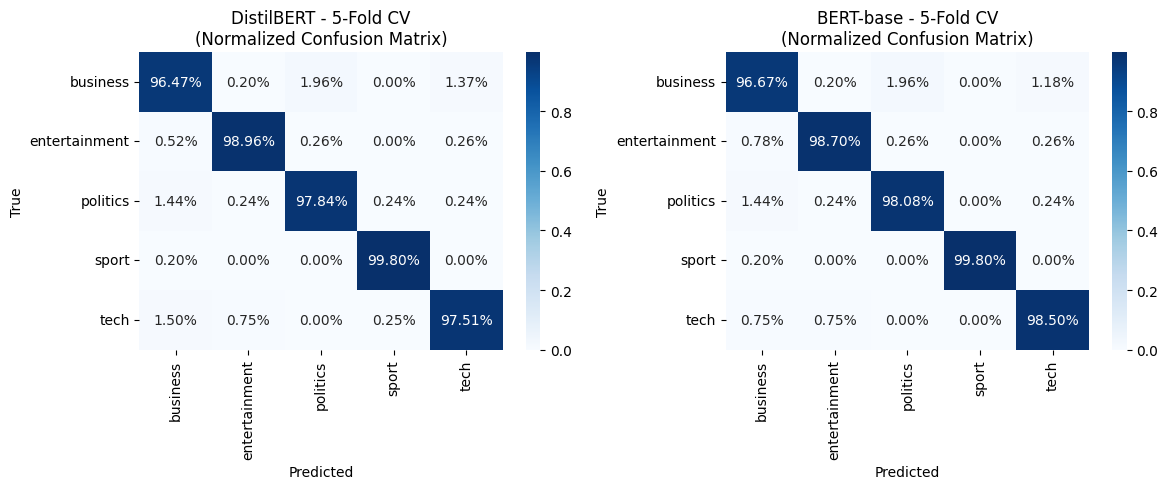

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(6*len(MODEL_NAMES), 5))

if len(MODEL_NAMES) == 1:
    axes = [axes]

for ax, model_name in zip(axes, MODEL_NAMES):
    y_true = all_predictions[model_name]["y_true"]
    y_pred = all_predictions[model_name]["y_pred"]
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=labels_sorted, yticklabels=labels_sorted, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    
    # Kurzer Name für Titel
    short_name = "DistilBERT" if "distilbert" in model_name else "BERT-base"
    ax.set_title(f'Normalized Confusion Matrix – {short_name} (5-Fold CV)')

plt.tight_layout()

cm_plot_path = RESULTS_DIR / "cv_transformer_confusion_matrices.png"
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Saved: {cm_plot_path}")
plt.show()

## Accuracy-Vergleich über Folds (Boxplot)

Saved: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_transformer_accuracy_boxplot.png


C:\Users\tanja\AppData\Local\Temp\ipykernel_64692\1286713302.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="Accuracy", data=df_plot, ax=ax, palette="Set2")


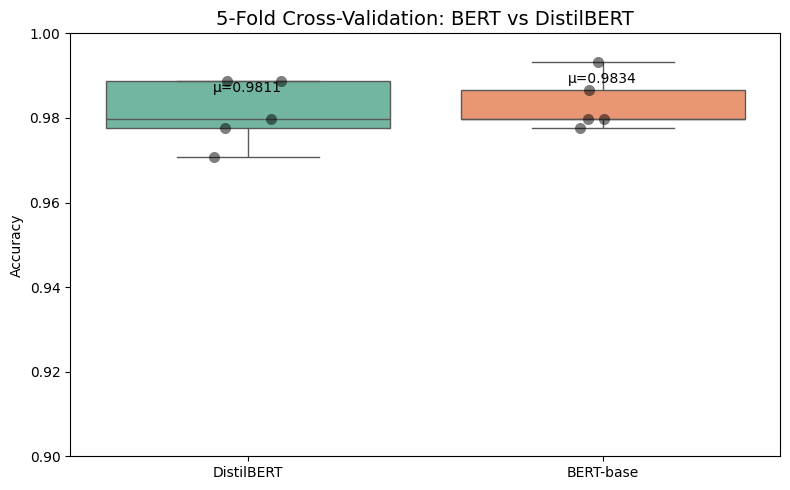

In [11]:
# Boxplot: Accuracy-Vergleich BERT vs DistilBERT über alle Folds
fig, ax = plt.subplots(figsize=(8, 5))

# Daten für Boxplot vorbereiten
plot_data = []
for model_name in MODEL_NAMES:
    model_df = df_cv[df_cv["model"] == model_name]
    short_name = "DistilBERT" if "distilbert" in model_name else "BERT-base"
    for acc in model_df["eval_accuracy"]:
        plot_data.append({"Model": short_name, "Accuracy": acc})

df_plot = pd.DataFrame(plot_data)

sns.boxplot(x="Model", y="Accuracy", data=df_plot, ax=ax, palette="Set2")
sns.stripplot(x="Model", y="Accuracy", data=df_plot, ax=ax, color='black', alpha=0.5, size=8)

ax.set_title("5-Fold Cross-Validation: BERT vs DistilBERT", fontsize=14)
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
ax.set_ylim(0.9, 1.0)

# Mittelwerte annotieren
for i, model_name in enumerate(MODEL_NAMES):
    mean_acc = df_cv[df_cv["model"] == model_name]["eval_accuracy"].mean()
    ax.text(i, mean_acc + 0.005, f'μ={mean_acc:.4f}', ha='center', fontsize=10)

plt.tight_layout()

boxplot_path = RESULTS_DIR / "cv_transformer_accuracy_boxplot.png"
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
print(f"Saved: {boxplot_path}")
plt.show()

## Gesamtvergleich: Baseline vs. BERT vs. DistilBERT (5-Fold CV)

Saved: c:\CAS\cas-ml-document-classification\results\cross_validation\cv_comparison_all_models.png


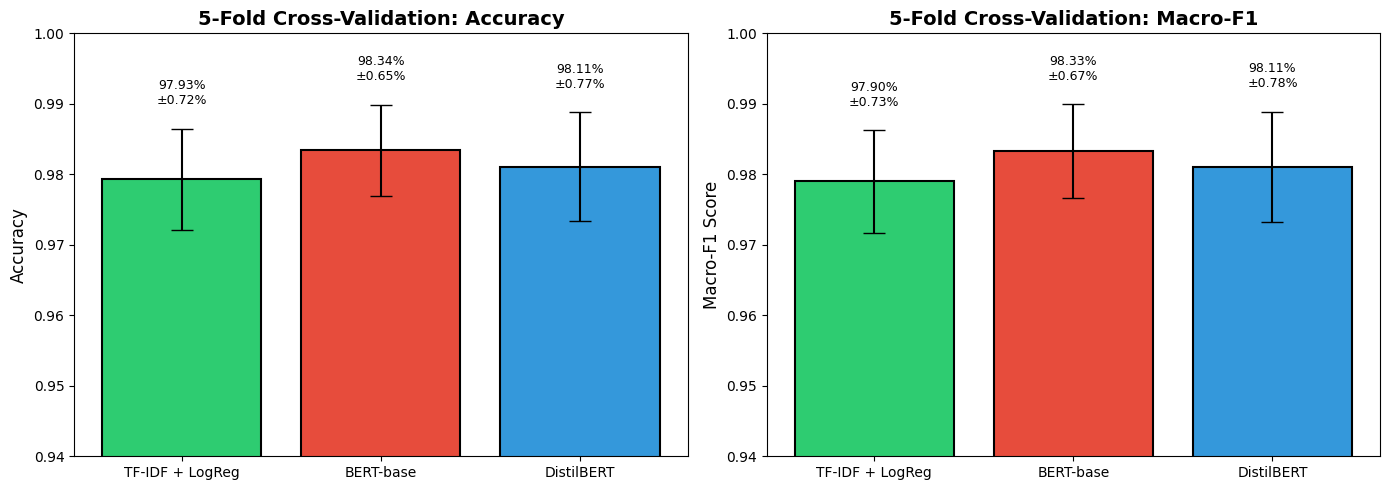

In [12]:
# Baseline-Ergebnisse laden
cv_baseline_path = RESULTS_DIR / "cv_baseline_5fold_summary.csv"
cv_baseline = pd.read_csv(cv_baseline_path)

# Alle Modelle zusammenfassen
all_models = ['TF-IDF + LogReg', 'BERT-base', 'DistilBERT']
colors = ['#2ecc71', '#e74c3c', '#3498db']  # Grün, Rot, Blau

# Daten aus den CSVs extrahieren
acc_means = [cv_baseline['acc_mean'].values[0]]
acc_stds = [cv_baseline['acc_std'].values[0]]
f1_means = [cv_baseline['mf1_mean'].values[0]]
f1_stds = [cv_baseline['mf1_std'].values[0]]

# BERT und DistilBERT aus unserem summary DataFrame
for model_name in ["bert-base-uncased", "distilbert-base-uncased"]:
    model_data = summary[summary["model"] == model_name]
    acc_means.append(model_data['acc_mean'].values[0])
    acc_stds.append(model_data['acc_std'].values[0])
    f1_means.append(model_data['f1_mean'].values[0])
    f1_stds.append(model_data['f1_std'].values[0])

# Plot erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
ax1 = axes[0]
bars1 = ax1.bar(all_models, acc_means, yerr=acc_stds, capsize=8, color=colors, 
                edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('5-Fold Cross-Validation: Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0.94, 1.0)

for bar, mean, std in zip(bars1, acc_means, acc_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.003, 
             f'{mean:.2%}\n±{std:.2%}', ha='center', va='bottom', fontsize=9)

# Macro-F1 Plot
ax2 = axes[1]
bars2 = ax2.bar(all_models, f1_means, yerr=f1_stds, capsize=8, color=colors, 
                edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Macro-F1 Score', fontsize=12)
ax2.set_title('5-Fold Cross-Validation: Macro-F1', fontsize=14, fontweight='bold')
ax2.set_ylim(0.94, 1.0)

for bar, mean, std in zip(bars2, f1_means, f1_stds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.003, 
             f'{mean:.2%}\n±{std:.2%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Speichern
comparison_path = RESULTS_DIR / "cv_comparison_all_models.png"
plt.savefig(comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {comparison_path}")
plt.show()